# Topic Modeling - LDA

In [3]:
import glob
from datetime import datetime
import logging
import logging as log
import gensim
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import CoherenceModel
from sklearn.externals import joblib
import gzip
from multiprocessing import Pool
from topic_coherence import ModelSimilarity, WithinTopicMeasure
import math

%matplotlib notebook
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
%%time 

# dataset = 'karbala'
dataset = 'all'

corpus_dictionary_file = 'data/eos/ngram/bigram_dict_'+dataset+'.dict'
corpus_doc2bow_file = 'data/eos/ngram/bigram_bow_corpus_'+dataset+'.mm'

# Load to memory
corpus = gensim.corpora.MmCorpus(corpus_doc2bow_file)
dictionary = gensim.corpora.Dictionary.load(corpus_dictionary_file)

# tfidf = gensim.models.TfidfModel(corpus) # step 1 -- initialize a model
# corpus_tfidf = tfidf[corpus] # Step 2 -- create tfidf
# print(corpus_tfidf)

print(corpus)
print(dictionary)


MmCorpus(460187 documents, 100000 features, 86073196 non-zero entries)
Dictionary(100000 unique tokens: ['volledig_afhankelijk', 'wildlife_trafficking', 'footsteps', 'waechtersbach', 'dfid']...)
CPU times: user 60 ms, sys: 12 ms, total: 72 ms
Wall time: 66.8 ms


In [ ]:
def generate_lda(dictionary, corpus, limit):
    """
    Function to generate num_topics - LDA  
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Range is incremented by 2
    """
    for num_topics in range(10, limit + 2, 2):
        print("Starting num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
        print('data/eos/lda/%02d_LDAmodel_EOS.pkl' % num_topics)
        lm = gensim.models.ldamulticore.LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, 
                                                     chunksize=2000, workers=7)
        joblib.dump(lm, 'data/eos/lda/%02d_LDAmodel_EOS.pkl' % num_topics)
        print("Finished num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))

In [ ]:
%%time


generate_lda(dictionary=dictionary, corpus=corpus, limit=30)

# LDA evaluation

In [5]:
# To get the topic words from the model
def get_topics(ldamodel, num_topics, num_words):
    topics = []
    for topic_id, topic in ldamodel.show_topics(num_topics=num_topics, num_words=num_words, formatted=False):
        topic = [word for word, _ in topic]
        topics.append(topic)
    return topics

# ldamodel = joblib.load('data/eos/lda/28_LDAmodel_EOS.pkl') 
# print(get_topics(ldamodel))

In [6]:
class MyDocuments(object):
    def __init__(self, dirname):
        self.dirname = dirname
 
    def __iter__(self):
        with gzip.open(self.dirname, 'rb') as f:
            for line in f:
                yield line.decode().split('\t')[1].split()

In [13]:
%%time
               

def eval_lda(fname, corpus_text, topic_num):
    
    ldamodel = joblib.load(fname) 
    print("Topic modeling loaded, starting coherence calculation " + fname + datetime.now().strftime("%H:%M:%S"))
    cm = CoherenceModel(dictionary=dictionary, corpus=corpus, 
                        texts=corpus_text, topics=get_topics(ldamodel, topic_num, 10), coherence='c_v')
#     print(cm)
    coherence = cm.get_coherence()
    print("finished model " + fname + " coherence {} ".format(coherence) + datetime.now().strftime("%H:%M:%S"))
    return [topic_num, coherence]


def execute_eval(topic_model_path):
    model_list = glob.glob(topic_model_path)
    model_list.sort()
    corpus_text = MyDocuments('data/eos/ngram/bigram_transformed_docs_%s.gz' % 'all')
    coherence_list = []
    for fname in model_list:
        topic_num = int(fname[13:15])
        coherence = eval_lda(fname, corpus_text, topic_num)
        coherence_list.append(coherence)
    
    coherence_list.sort(key=lambda x: x[0])
    print(coherence_list)
        
    # Show graph
    indices = [x[0] for x in coherence_list]
    y = [abs(x[1]) for x in coherence_list]
    n = len(coherence_list)
    x = range(n)
    plt.bar(x, y, width=0.2, tick_label=indices, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')
    plt.show()
    plt.savefig('data/eos/graphs/%s_coherence.png' % topic_model_path[15:-4], dpi=1200)


CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.1 µs


Topic modeling loaded, starting coherence calculation data/eos/lda/10_Malletmodel_EOS.pkl16:01:36
finished model data/eos/lda/10_Malletmodel_EOS.pkl coherence 0.5496078349912115 16:09:24


Topic modeling loaded, starting coherence calculation data/eos/lda/12_Malletmodel_EOS.pkl16:09:25
finished model data/eos/lda/12_Malletmodel_EOS.pkl coherence 0.5303986079101294 16:17:46


Topic modeling loaded, starting coherence calculation data/eos/lda/14_Malletmodel_EOS.pkl16:17:47
finished model data/eos/lda/14_Malletmodel_EOS.pkl coherence 0.5406563556503123 16:26:33


Topic modeling loaded, starting coherence calculation data/eos/lda/16_Malletmodel_EOS.pkl16:26:33
finished model data/eos/lda/16_Malletmodel_EOS.pkl coherence 0.5503466393589955 16:35:53


Topic modeling loaded, starting coherence calculation data/eos/lda/18_Malletmodel_EOS.pkl16:35:54
finished model data/eos/lda/18_Malletmodel_EOS.pkl coherence 0.5472261200456003 16:46:32


Topic modeling loaded, starting coherence calculation data/eos/lda/20_Malletmodel_EOS.pkl16:46:32
finished model data/eos/lda/20_Malletmodel_EOS.pkl coherence 0.5901759393644 16:57:02


Topic modeling loaded, starting coherence calculation data/eos/lda/22_Malletmodel_EOS.pkl16:57:03
finished model data/eos/lda/22_Malletmodel_EOS.pkl coherence 0.593256300008004 17:08:14


Topic modeling loaded, starting coherence calculation data/eos/lda/24_Malletmodel_EOS.pkl17:08:14
finished model data/eos/lda/24_Malletmodel_EOS.pkl coherence 0.6022534064710882 17:20:07


Topic modeling loaded, starting coherence calculation data/eos/lda/26_Malletmodel_EOS.pkl17:20:07
finished model data/eos/lda/26_Malletmodel_EOS.pkl coherence 0.5765662381051471 17:32:30


Topic modeling loaded, starting coherence calculation data/eos/lda/28_Malletmodel_EOS.pkl17:32:31
finished model data/eos/lda/28_Malletmodel_EOS.pkl coherence 0.5883520732235485 17:45:41


Topic modeling loaded, starting coherence calculation data/eos/lda/30_Malletmodel_EOS.pkl17:45:42
finished model data/eos/lda/30_Malletmodel_EOS.pkl coherence 0.5945812460683686 17:59:37
[[10, 0.54960783499121146], [12, 0.53039860791012938], [14, 0.54065635565031234], [16, 0.55034663935899553], [18, 0.54722612004560034], [20, 0.59017593936440005], [22, 0.593256300008004], [24, 0.60225340647108816], [26, 0.57656623810514707], [28, 0.58835207322354854], [30, 0.5945812460683686]]


<IPython.core.display.Javascript object>


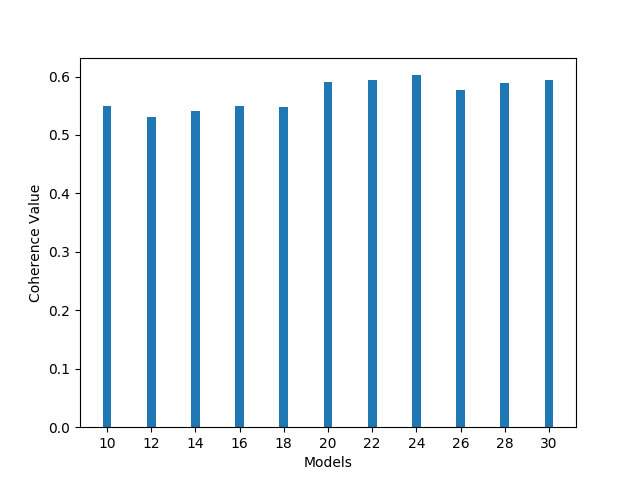

CPU times: user 16min 26s, sys: 7.52 s, total: 16min 34s
Wall time: 1h 58min 2s


In [12]:
%%time

# topic_model_path = 'data/eos/lda/*_LDAmodel_EOS.pkl'
# topic_model_path = 'data/eos/lda/*_LSImodel_EOS.pkl'
topic_model_path = 'data/eos/lda/*_Malletmodel_EOS.pkl'
execute_eval(topic_model_path)

# Evaluate topic LSA Mallet models

In [8]:
def mallet_lda_build(num_topics, dictionary, corpus, mallet_model_path):
    mallet_bin = '/home/sonic/sonic/mallet-2.0.8/bin/mallet'
    print ("start modeling LDA Mallet " + datetime.now().strftime("%H:%M:%S"))
    lda_mallet_model = gensim.models.wrappers.LdaMallet(mallet_bin, corpus=corpus, workers=7,
                                               num_topics=num_topics, id2word=dictionary)

    joblib.dump(lda_mallet_model, mallet_model_path)
    print ("finished modeling LDA Mallet, number of topics {}, ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
    return lda_mallet_model


In [9]:
def lsi_model_build(num_topics, dictionary, corpus, lsi_model_path):
    print ("start modeling lsi " + datetime.now().strftime("%H:%M:%S"))
    lsimodel = gensim.models.lsimodel.LsiModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
    joblib.dump(lsimodel, lsi_model_path)
    #     lsimodel.show_topics(num_topics=10)  # Showing only the top 5 topics
    print ("finished modeling lsi, number of topics {}, ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
    return lsimodel


In [10]:
%%time 


def generate_mallet(dictionary, corpus, limit):
    """
    Function to generate num_topics - LDA  
    
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : topic limit

    Range is incremented by 2
    """
    for num_topics in range(10, limit + 2, 2):
        print("Starting num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
        mallet_model_path = 'data/eos/lda/%02d_Malletmodel_EOS.pkl' % num_topics
        mallet_lda_build(num_topics, dictionary, corpus, mallet_model_path)
        print("Finished num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))

def generate_lsi(dictionary, corpus, limit):
    for num_topics in range(10, limit + 2, 2):
        print("Starting num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
        lsi_model_path = 'data/eos/lda/%02d_LSImodel_EOS.pkl' % num_topics
        lsi_model_build(num_topics, dictionary, corpus, lsi_model_path)
        print("Finished num topic {} ".format(num_topics) + datetime.now().strftime("%H:%M:%S"))
    

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 4.77 µs


In [57]:
%%time


generate_lsi(dictionary, corpus, limit)

Starting num topic 10 19:44:40
start modeling lsi 19:44:40
finished modeling lsi, number of topics 10, 19:50:41
Finished num topic 10 19:50:41
Starting num topic 12 19:50:41
start modeling lsi 19:50:41
finished modeling lsi, number of topics 12, 19:56:47
Finished num topic 12 19:56:47
Starting num topic 14 19:56:47
start modeling lsi 19:56:47
finished modeling lsi, number of topics 14, 20:02:41
Finished num topic 14 20:02:41
Starting num topic 16 20:02:41
start modeling lsi 20:02:41
finished modeling lsi, number of topics 16, 20:08:34
Finished num topic 16 20:08:34
Starting num topic 18 20:08:34
start modeling lsi 20:08:34
finished modeling lsi, number of topics 18, 20:14:41
Finished num topic 18 20:14:41
Starting num topic 20 20:14:41
start modeling lsi 20:14:41
finished modeling lsi, number of topics 20, 20:21:09
Finished num topic 20 20:21:09
Starting num topic 22 20:21:09
start modeling lsi 20:21:09
finished modeling lsi, number of topics 22, 20:27:23
Finished num topic 22 20:27:23

In [11]:
%%time

limit = 30
generate_mallet(dictionary, corpus, limit)

Starting num topic 10 01:10:12
start modeling LDA Mallet 01:10:13
finished modeling LDA Mallet, number of topics 10, 02:20:08
Finished num topic 10 02:20:08
Starting num topic 12 02:20:08
start modeling LDA Mallet 02:20:08
finished modeling LDA Mallet, number of topics 12, 03:28:58
Finished num topic 12 03:28:58
Starting num topic 14 03:28:58
start modeling LDA Mallet 03:28:58
finished modeling LDA Mallet, number of topics 14, 04:38:31
Finished num topic 14 04:38:31
Starting num topic 16 04:38:31
start modeling LDA Mallet 04:38:31
finished modeling LDA Mallet, number of topics 16, 06:02:53
Finished num topic 16 06:02:53
Starting num topic 18 06:02:53
start modeling LDA Mallet 06:02:53
finished modeling LDA Mallet, number of topics 18, 07:18:17
Finished num topic 18 07:18:17
Starting num topic 20 07:18:17
start modeling LDA Mallet 07:18:17
finished modeling LDA Mallet, number of topics 20, 08:35:29
Finished num topic 20 08:35:29
Starting num topic 22 08:35:29
start modeling LDA Mallet 0

In [ ]:
#(ldamodel.print_topics(num_topics=20, num_words=10))

In [ ]:
# Visualize the LDA topics
pyLDAvis.enable_notebook()

lda_vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_vis)

In [6]:
def explore_topic(ldamodel, topic_number, topn=30):
    """
    accept a user-supplied topic number and
    print out a formatted list of the top terms
    """
        
    print (u'{:20} {}'.format(u'term', u'frequency') + u'\n')

    for term, frequency in ldamodel.show_topic(topic_number, topn=30):
        print (u'{:20} {:.3f}'.format(term, round(frequency, 3)))

In [13]:
ldamodel = joblib.load('data/eos/lda/28_LDAmodel_EOS.pkl') 
explore_topic(ldamodel=ldamodel,topic_number=23)


term                 frequency

people               0.010
school               0.007
one                  0.006
woman                0.006
child                0.005
go                   0.005
take                 0.005
can                  0.005
student              0.005
time                 0.004
work                 0.004
come                 0.004
like                 0.004
many                 0.004
life                 0.004
make                 0.004
now                  0.004
get                  0.004
day                  0.003
city                 0.003
know                 0.003
also                 0.003
government           0.003
want                 0.003
family               0.003
just                 0.003
see                  0.003
man                  0.003
give                 0.003
tell                 0.003
